# Markov Chain Monte Carlo (MCMC)

## MCMC  в задаче байесовской оценки параметров

Байесовская оценка параметров при данной выборке X получается из  формулы Байеса

$$p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{p(X)}$$

Здесь
* $p(\theta)$ - prior (априорное распределение)
* $p(X \ | \ \theta)$ - likelihood (правдоподобие)
* $p(\theta \ | \ X)$ - posterior (апостериорное распределение)
* $p(X) = \int p(X \ | \ \theta) p(\theta) \rm d\theta$ - evidence or marginal likelihood (маргинальное/безусловное распределение выборки)

Разберем пример. Будем подбрасывать монету, $\theta$ - неизвестный параметр успеха (вероятность выпадения орла). Пусть в выборке $Х$ размера $N$ случилось $k$ успехов, тогда правдоподобие выборки $X$:

$$p(X \ | \ \theta) = \theta^k(1-\theta)^{N-k}.$$


В качесте
априорного распределения выберем бета-распределение $Beta(a, b)$:

$$p(\theta) = \frac{1}{B(a, b)}\theta^{a-1}(1-\theta)^{b-1}.$$

Примеры плотностей бета-распределений:

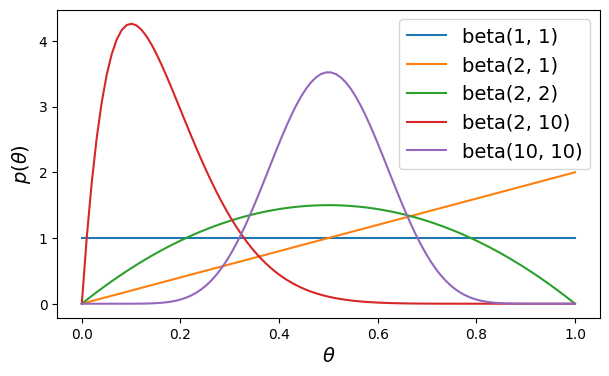

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7, 4))
fig.patch.set_facecolor('xkcd:white')

x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, 1, 1), label='beta(1, 1)')
plt.plot(x, stats.beta.pdf(x, 2, 1), label='beta(2, 1)')
plt.plot(x, stats.beta.pdf(x, 2, 2), label='beta(2, 2)')
plt.plot(x, stats.beta.pdf(x, 2, 10), label='beta(2, 10)')
plt.plot(x, stats.beta.pdf(x, 10, 10), label='beta(10, 10)')
plt.legend(fontsize=14)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel(r'$p(\theta)$', fontsize=14)
plt.show()

Пусть эксперимент с подбрасывание монеты $N$=100 раз завершился $k$=61 успехом, а параметрами априорного распределения являлись $a=b=10$.
Как построить график апостериорного распределения?


Попробуем построить по точкам:
* для каждого значения $\theta$ найдем произведение плотностей правдоподобия и априорного распределения
* вычислим нормировочный интеграл

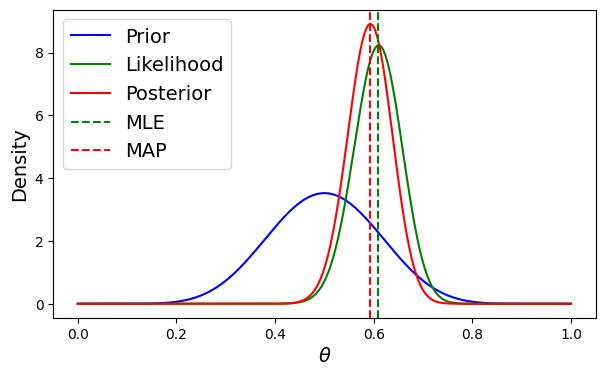

In [2]:
from scipy import stats

a, b = 10, 10

N = 100
k = 61

prior = stats.beta(a, b)
likelihood = lambda thetas: stats.binom(N, thetas).pmf(k)

thetas = np.linspace(0, 1, 200)
post = likelihood(thetas) * prior.pdf(thetas)
post /= post.mean()

fig = plt.figure(figsize=(7, 4))
fig.patch.set_facecolor('xkcd:white')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, (N+1)*likelihood(thetas), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.axvline(thetas[np.argmax(likelihood(thetas))], c='green', ls='--', label='MLE')
plt.axvline(thetas[np.argmax(post)], c='red', ls='--', label='MAP')
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.show()

Точка максимума правдоподобия называется оценкой MLE (maximum likelihood estimation), точка максимума апостериорной плотности - оценкой MAP (maximum a posteriori probability).

В прикладных задачах, размерность параметра $\theta$ может быть большой (очень большой). Будет затруднительно построить график по точкам и вычислить нормировочный интеграл.

Небольшое отступление. В задаче с монеткой можно заметить, что произведение биномиальной плотности правдоподобия и априорного бета-распределения по форме совпадает с бета-распределением (отсюда говорят, что бета является *сопряженным* априорным распределением к биномиальному):

$$\theta^k(1-\theta)^{N-k} \times \theta^{a-1}(1-\theta)^{b-1} =
\theta^{k+a-1}(1-\theta)^{N-k+b-1}$$

Следовательно, апостериорное распределнеие является $Beta(k+a, N-k+b)$. Модой этого распределения будет $$MAP = \frac{k+a-1}{N+a+b-2}.$$

Для k=61, N=100, a=b=10 получим MAP = 0.593, в то же время, MLE = 0.61.

Вернемся к задаче нахождения апостериорной плотности и вместо построения плотности по точкам применим новый подход - будем моделировать выборку из целевого (апостериорного) распределения.

## Metropolis sampler (частный случай общего подхода MCMC)

Общая идея MCMC:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше целевое распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из целевого распределения.

Алгоритм Metropolis sampling:
* пусть $\pi$ - целевое распределение (не обязательно нормированное к 1) на множестве $\Omega$ (например, $\Omega=R^d$)
* выберем произвольное $X_0$ из $\Omega$
* зададим $q(y|x)$ - плотность переходных вероятностей на $\Omega$. Например, $q(y|x)$ - гауссовское распределение $N(x, I\sigma^2)$
* для текущего $X_n$ смоделируем значение $Y$ из распределения $q(y|X_n)$
* вычислим $\alpha = \frac{\pi(Y)}{\pi(X_n)}$
* смоделируем случайную величину $u$ из равномерного распределения на [0, 1]
* если $u<\alpha$, то $X_{n+1} = Y$, иначе $X_{n+1} = X_{n}$.

MCMC demo http://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana

Реализация алгоритма Metropolis:

In [3]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    '''Generic Metropolis scheme.
    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density (unnormalized) at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

Для задачи с монеткой целевая плотность пропорциональна правдоподобию Х априорное распределение, запишем это:

In [4]:
def value(theta, **kwargs):
    _ = kwargs
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(theta) * prior.pdf(theta)

Пробные шаги будем моделировать с помощью одномерного нормального распределения:

In [1]:
def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

Все готово, теперь зададим начальную точку х=0.2, величину шага будет характеризовать параметр sigma=0.1, сделаем 3000 шагом по цепи Маркова:

In [6]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.1)

По полученному массива состояний построим гистограмму и сравним ее с точным аналитическим ответом (красная линия):

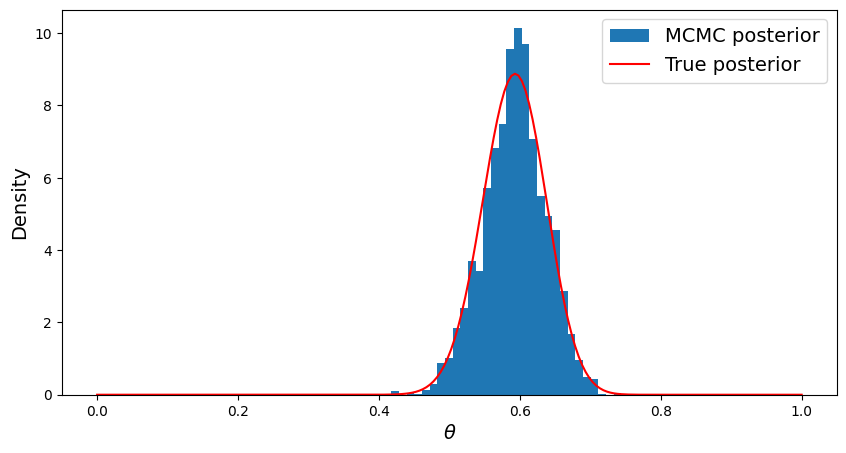

In [7]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
plt.hist(post, bins=50, density=True, label='MCMC posterior')
plt.plot(thetas, stats.beta(k+a, N-k+b).pdf(np.linspace(0, 1, 200)),
         label='True posterior', c='red')
plt.legend(fontsize=14)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

Мы видим, что выборочная гистограмма хорошо приближает искомую плотность. А это значит, что состояния построенной цепи Маркова можно считать выборкой из искомой плотности.

Посмотрим, как выглядит траектория блуждания (напомним, стартовали из точки х=0.2). По горизонтальной оси - номер шага, по вертикали - состояние). Траектория блуждания:

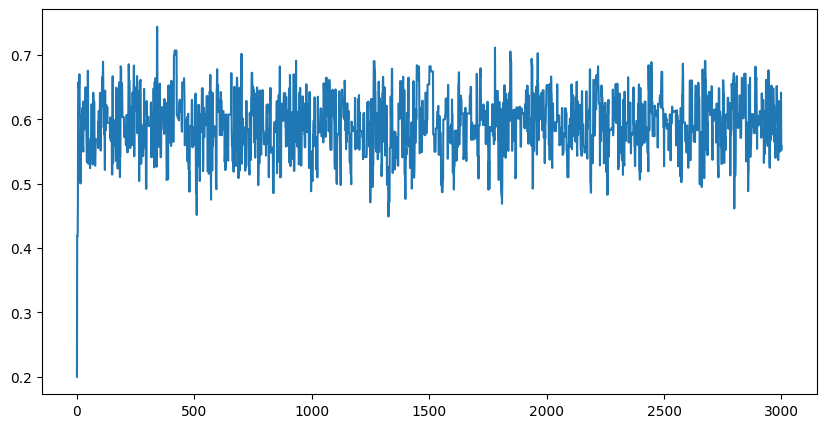

In [8]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(post)
plt.show()

### Выбор ширины шага

Посмотрим, как параметр sigma (характерная длина шага) сказывается на траектории:

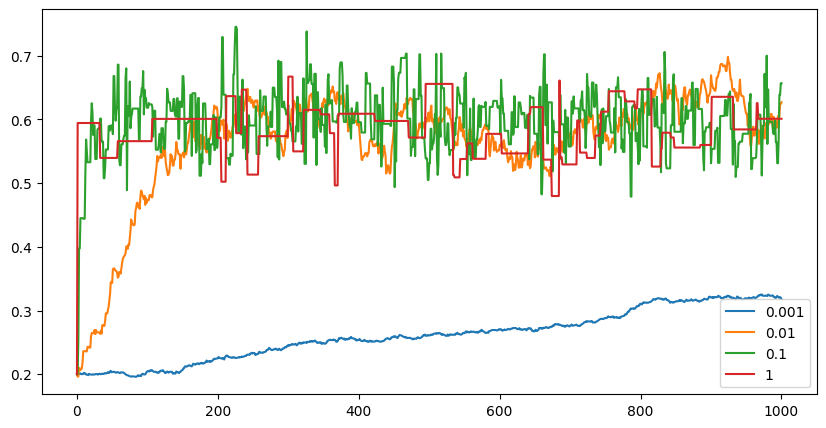

In [9]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
for sigma in [0.001, 0.01, 0.1, 1]:
    post = metroplis(0.2, value, proposal, 1000, sigma=sigma)
    plt.plot(post, label=sigma)
plt.legend()
plt.show()

Вывод: шаг sigma=0.1 (зеленая траектория) оказался удачным выбором. С шагом sigma=0.001 мы бы еще долго шли в область, где сосредоточена искомая плотность, а с шагом 1 мы часто вылетаем за область допустимых значений параметра и в результате просто стоим на месте.


### Выбор начального приближения

Насколько влияем выбор начального состояния? Попробуем стартовать из разных точек отрезка [0, 1]:

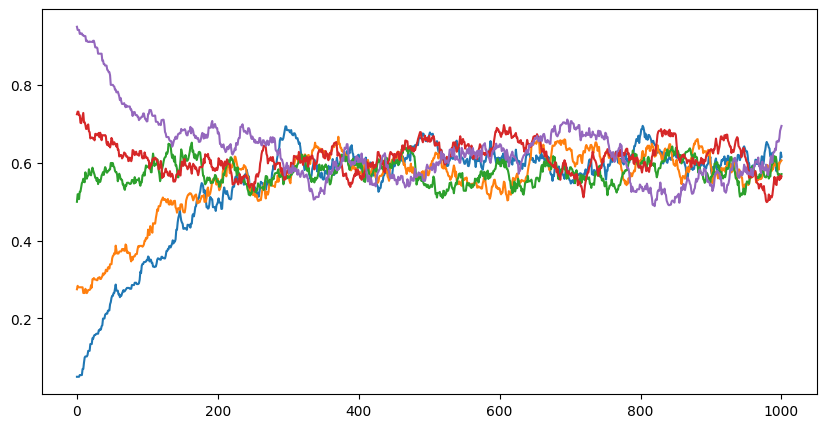

In [10]:
fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
for start in np.linspace(0.05, 0.95, 5):
    post = metroplis(start, value, proposal, 1000, sigma=0.01)
    plt.plot(post)
plt.show()

Вывод: при любом выборе начального состояния мы сходимся к целевому распределению, но имеет смысл отбрасывать начальный участок последовательной выборки.

### Анализ корреляций

Нам бы хотелось получать выборку из независимых случайных величин, но понятно, что два соседних шага сильно связаны между собой. Посмотрим, через сколько шагом связь "забывается":

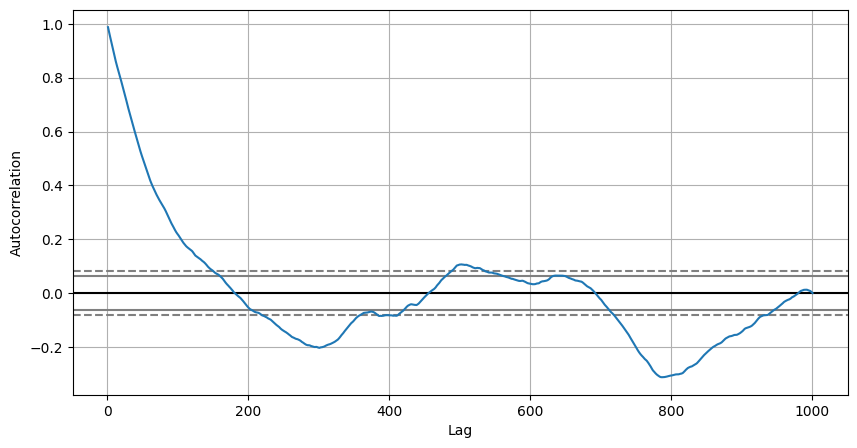

In [11]:
import pandas as pd

fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
pd.plotting.autocorrelation_plot(post, ax=ax)
plt.show()

Вывод: есть смысл прореживать выборку и брать элементы с шагом, например, 200.

### Проверка стационарности

Как проверить, что мы достигли стационарного состояния? Зарнее указать требуемое число шагов трудно, но, обладая куском ряда, можно проверить его на стационарность. Например, так:
разбиваем выборку на начальный и конечный куски $x_s$, $x_e$ и вычисляем статистику t-критерия Стьюдента для проверки совпадения параметров распределения в этих кусках. У стационарного ряда выборка, взятая в начале, не должна отличаться по статистическим свойствам от выборки, взятой в конце ряда.

In [12]:
def g_test(x, start=0.1, end=0.5):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):])

Проверим для sigma=0.1:

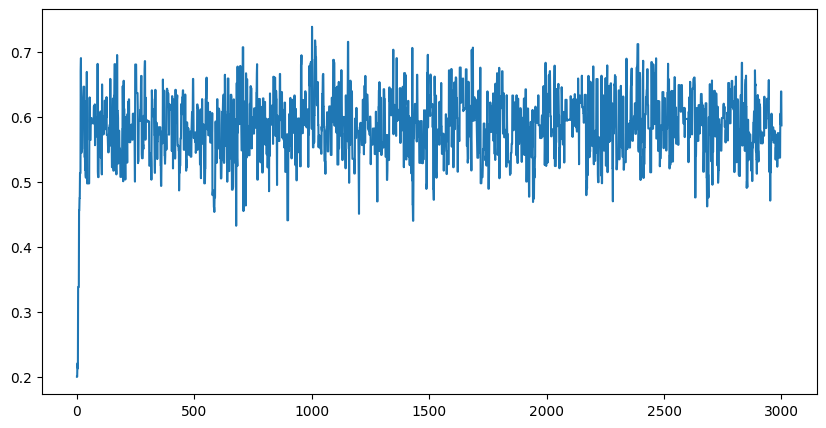

TtestResult(statistic=-1.077404497420273, pvalue=0.2814491139132309, df=1738.0)

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')

post = metroplis(0.2, value, proposal, 3000, sigma=0.1)
plt.plot(post)
plt.show()

g_test(post[100:])

Вывод: гипотезу стациoнарности не отвергаем.

Проверим для sigma=0.01:

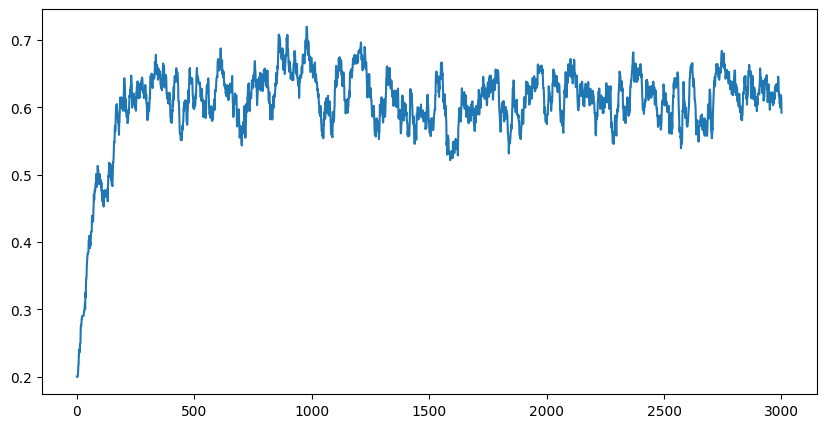

TtestResult(statistic=-0.21689099602083226, pvalue=0.8283228286587443, df=1498.0)

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')

post = metroplis(0.2, value, proposal, 3000, sigma=0.01)
plt.plot(post)
plt.show()

g_test(post[500:])

Вывод: стационарность не подтверждается. Нужно рассматривать более длинные последовательности:

In [15]:
post = metroplis(0.2, value, proposal, 30000, sigma=0.01)
g_test(post[1000:])

TtestResult(statistic=-1.0853049621327315, pvalue=0.27780164675666635, df=17398.0)

## Домашнее задание

### Задача 1
Примените алгоритм Metropolis для генерации выборки из распределения с плотностью
p(x) = 0.3N(-4, 2) + 0.7N(3, 6), где N(a, b) - плотность нормального распределения со средним a и дисперсией b. Для наглядности, ниже приведен график плотности смеси. Покажите, что гистограмма, построенная по выборке, приближает заданную плотность смеси.

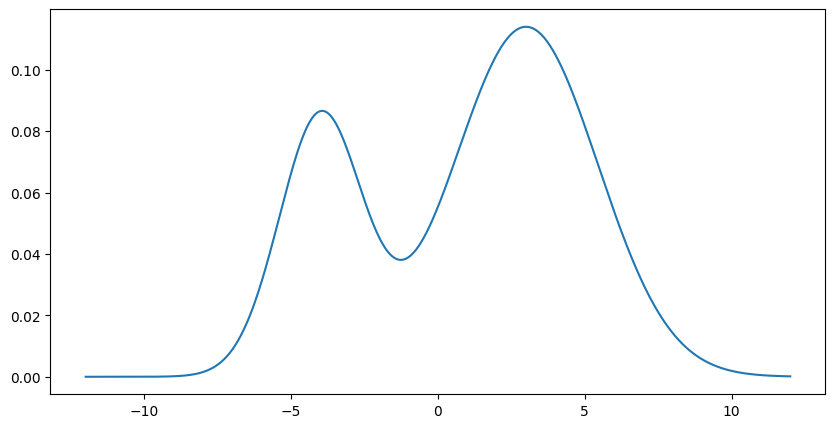

In [36]:
from scipy.stats import norm

x = np.linspace(-12, 12, 1000)
y = 0.3*norm(-4, np.sqrt(2)).pdf(x) + 0.7*norm(3, np.sqrt(6)).pdf(x)

fig, ax = plt.subplots(1, figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, y)
plt.show()

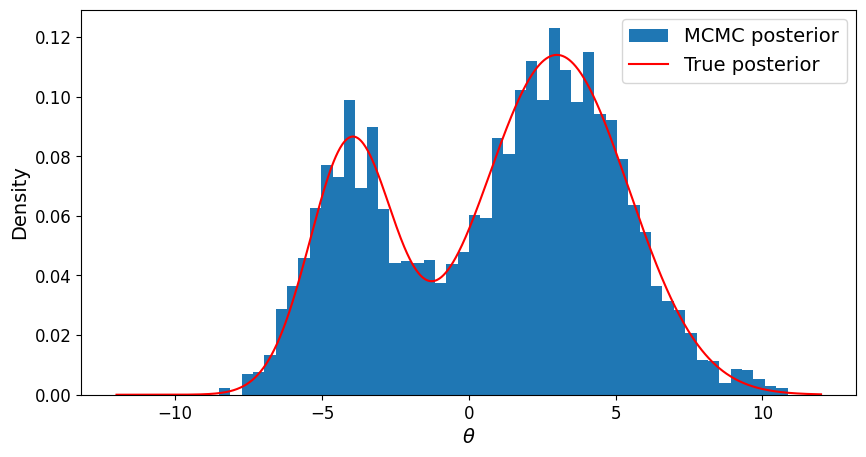

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

def value(theta, **kwargs):
    _ = kwargs
    if theta < -12 or theta > 12:
        return 0
    else:
        return likelihood(theta)

thetas = np.linspace(0, 1, 200)
likelihood = lambda thetas: 0.3*norm(-4, np.sqrt(2)).pdf(thetas) + 0.7*norm(3, np.sqrt(6)).pdf(thetas)
post = metroplis(0.2, value, proposal, 6000, sigma=4)

x = np.linspace(-12, 12, 1000)
y = 0.3*norm(-4, np.sqrt(2)).pdf(x) + 0.7*norm(3, np.sqrt(6)).pdf(x)

fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
plt.hist(post, bins=50, density=True, label='MCMC posterior')
plt.plot(x, y, label='True posterior', c='red')
plt.legend(fontsize=14)
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Задача 2
Рассмотрим граф $G=(V,E)$, вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1. Пример допустимой расстановки значений по вершинам графа показан на картинке ниже (черные вершины имеют значение 1, белые - 0):

<!-- ![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg) -->

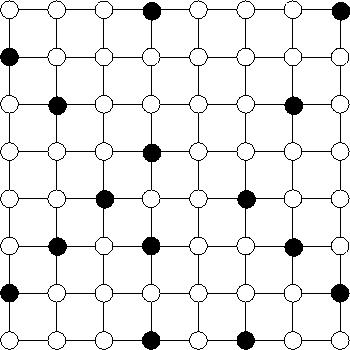

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех $2^V$ конфигураций:
$$\begin{equation*}
\mu(\xi) =
 \begin{cases}
   \frac{1}{Z_G}, &\text{$\xi$ - допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$
{\rm E} n(\xi) = \sum\limits_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum\limits_{x \in \{0,1\}^V} n(x) {\rm I}_{\{x - \text{допустимая} \}}
$$

Явно перебирать все $x \in \{0,1\}^{V}$ не представляется возможным. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чиcел:
$$
{\rm E} n(\xi) \approx \frac{1}{N} \sum\limits_{i=1}^{N} n(\xi_i), \text{где $\xi_i$, $i=1,...,N$ - выборка случайных допустимых графов. }
$$

Для моделирования выборки можно применить метод MCMC:
1. выбираем случайную вершину
2. если в вершине можно заменить цвет - заменяем с вероятностью 0.5
3. добавляем граф в выборку
4. переходим на шаг 1

Задание
* Оценить  ${\rm E} n(\xi)$ для графа 10х10
* Построить график распределеиня $n(\xi)$

Совет: проверьте алгоритм на графах размера $2\times 2$. Ваш ответ должет быть близок к точному ответу (0+1+1+1+1+2+2)/7 = 8/7.

En(ξ)= 22.823333333333334


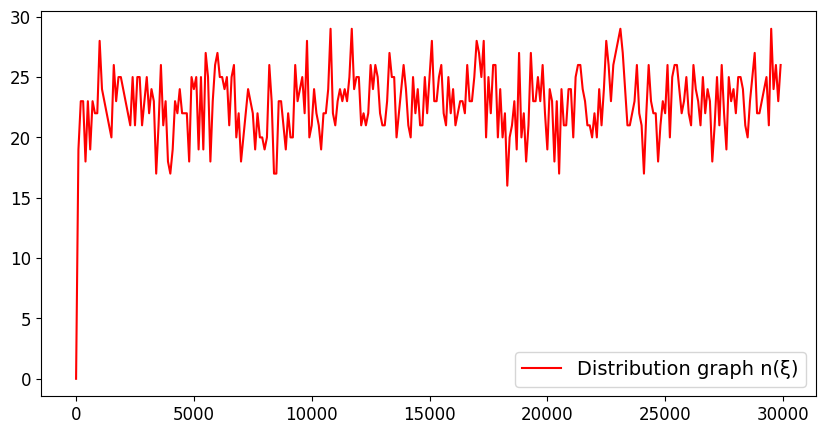

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def MCMC(graph, n):
  i=np.random.randint(0, n)
  j=np.random.randint(0, n)
  if graph[i][j]==0:
    if i==0:
      if j==0:
        if graph[i][j+1]!=1 and graph[i+1][j]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
      elif j==n-1:
        if graph[i][j-1]!=1 and graph[i+1][j]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
      else:
        if graph[i][j-1]!=1 and graph[i+1][j]!=1 and graph[i][j+1]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
    elif i==n-1:
      if j==0:
        if graph[i-1][j]!=1 and graph[i][j+1]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
      elif j==n-1:
        if graph[i][j-1]!=1 and graph[i-1][j]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
      else:
        if graph[i][j-1]!=1 and graph[i-1][j]!=1 and graph[i][j+1]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
    else:
      if j==0:
        if graph[i-1][j]!=1 and graph[i][j+1]!=1 and graph[i+1][j]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
      elif j==n-1:
        if graph[i-1][j]!=1 and graph[i][j-1]!=1 and graph[i+1][j]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
      else:
        if graph[i-1][j]!=1 and graph[i][j-1]!=1 and graph[i+1][j]!=1 and graph[i][j+1]!=1:
          if np.random.randint(0, 2)==1:
            graph[i][j]=1
  else:
    if np.random.randint(0, 2)==1:
      graph[i][j]=0
  return graph

n=10
N=30000
n_ksi=np.zeros(N)
graph=np.zeros((n, n))
for i in range (N):
  n_ksi[i]=np.sum(MCMC(graph, n))

print('En(ξ)=', np.sum(n_ksi[::100])/(N/100))

fig = plt.figure(figsize=(10, 5))
fig.patch.set_facecolor('xkcd:white')
plt.plot(np.arange(0, 30000, 100), n_ksi[::100], label='Distribution graph n(ξ)', c='red')
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Литература

*  http://probability.ca/jeff/ftpdir/johannes.pdf
* http://chi-feng.github.io/mcmc-demo/

[1] H. Haario, E. Saksman, and J. Tamminen, An adaptive Metropolis algorithm (2001)

[2] M. D. Hoffman, A. Gelman, The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo (2011)

[3] G. O. Roberts, R. L. Tweedie, Exponential Convergence of Langevin Distributions and Their Discrete Approximations (1996)

[4] Li, Tzu-Mao, et al. Anisotropic Gaussian mutations for metropolis light transport through Hessian-Hamiltonian dynamics ACM Transactions on Graphics 34.6 (2015): 209.

[5] Q. Liu, et al. Stein Variational Gradient Descent: A General Purpose Bayesian Inference Algorithm Advances in Neural Information Processing Systems. 2016.

[6] J. Buchner A statistical test for Nested Sampling algorithms Statistics and Computing. 2014.

[7] Cajo J. F. ter Braak & Jasper A. Vrugt Differential Evolution Markov Chain with snooker updater and fewer chains Statistics and Computing. 2008.